# Block #7: Turning images into data #

**How can we extract features from 3D data ?**

In this session, we'll simulate working with a CT mummy scan. We'll learn how to segment structures from 3d objects and how to extract descriptors from it. 

<img src="./img/mummy.jpeg" width="600" height="300">

**Topics covered in this session include:**
- 3D data preprocessing and visualization
- Image segmentation: thresholding 
- Connected component analysis and morphological operations
- Rendering
- Feature extraction with Scikit-Image

In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np
import glob
import os

# Data loading. Lets take one image.
data_path = './2-data/'
image_path = glob.glob(os.path.join(data_path, 'pat-10*.nii.gz'))[0]
ct_image = nib.load(image_path).get_fdata()

Image dimension: (512, 512, 33)
Number of voxels: 8650752
Min voxel intensity (density): -8389.0
Max voxel intensity (density): 28311.0
Mean voxel intensity (density): -630.7434952475808


(Text(0.5, 0, 'HU'), Text(0, 0.5, 'Freq'))

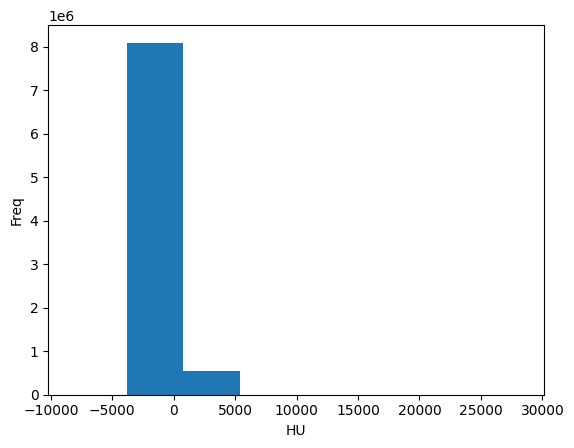

In [2]:
'''Lets inspect our image.
Basic computer tomography:  Hounsfield scale measures x-ray tissue attenuation.
In this scale:
                                                Hounsfield (HU) Scale
<----------------------------------------------------------------------------------------------------------------------->
  Air: −1000    FAT: [–30, –70]   Water: 0      Soft tissue: [20, 40]   Bone: [700, 2-3K]   Metals: > 2-3K      '''                                                       
                                                                    
# What are the image dimensions and the amount of voxels?
print('Image dimension:', ct_image.shape)
print('Number of voxels:', ct_image.size)

# What are the min, max, mean voxel intensities?
print('Min voxel intensity (density):', ct_image.flatten().min())
print('Max voxel intensity (density):', ct_image.flatten().max())
print('Mean voxel intensity (density):', ct_image.flatten().mean())

# Lets see the image intensity distribution
plt.hist(ct_image.flatten(), bins=8)
plt.xlabel('HU'), plt.ylabel('Freq')

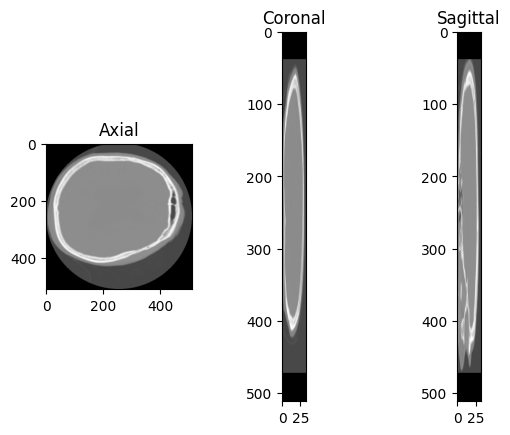

Voxels (i.e., the 3D version of pixels) are anisotropic
The reason lies in the image shape: the image has lower resolution in the z-axis


In [3]:
'''Lets visualize the image.
    Having a volume -3d object-, we can consider 2D planes or 'slices' to visualize it.
    We can visualize any plane; consider the xy, xz, and yz planes. In radiology, these are called the axial, coronal and sagittal planes.'''

plt.figure()
plt.subplot(1,3,1)
# axial plane- xy slice
plt.title('Axial')
plt.imshow(ct_image[:,:,20], cmap='gray')
plt.subplot(1,3,2)
# coronal plane- xz slice
plt.title('Coronal')
plt.imshow(ct_image[:,120,:], cmap='gray')
# sagital plane- yz slice.
plt.subplot(1,3,3)
plt.title('Sagittal')
plt.imshow(ct_image[120,:,:], cmap='gray')
plt.show()
print('Voxels (i.e., the 3D version of pixels) are anisotropic')
print('The reason lies in the image shape: the image has lower resolution in the z-axis')


New image shape: (256, 256, 256)


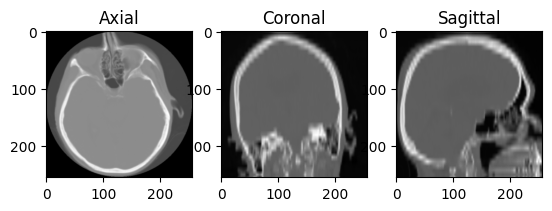

Looking better!


In [4]:
# Can we reshape our image?

from skimage.transform import resize
ct_resized = resize(ct_image, (256, 256, 256), anti_aliasing=True)
print('New image shape:', ct_resized.shape)


# Plotting our new image
plt.figure()
plt.subplot(1,3,1)
# axial plane- xy slice
plt.title('Axial')
plt.imshow(np.rot90(ct_resized[:,:,100]), cmap='gray')
plt.subplot(1,3,2)
# coronal plane- xz slice
plt.title('Coronal')
plt.imshow(np.rot90(ct_resized[:,120,:]), cmap='gray')
# sagital plane- yz slice.
plt.subplot(1,3,3)
plt.title('Sagittal')
plt.imshow(np.rot90(ct_resized[120,:,:]), cmap='gray')
plt.show()

print('Looking better!')

Not bad!
However, we see two problems. First, the thickness of the skull looks thin. Second, there are many deattached objects!


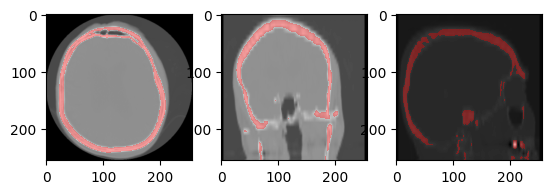

In [5]:
''' Let's segment the skull. To do so, we can retain 'hard tissue' (i.e. bone) voxels. According to our HU scale (see cell #1), 
   bone HU lies in the range (> 700 HU, 2-3k). 
   This can be done by thresholding the image. '''

from matplotlib.colors import ListedColormap
skull_msk = ct_resized > 700

cmap = ListedColormap(['none', 'red'])
plt.figure()
plt.subplot(1,3,1)
plt.imshow(np.rot90(ct_resized[:,:,160]), cmap='gray')
plt.imshow(np.rot90(skull_msk[:,:,160]), cmap=cmap, alpha=0.35) 
plt.subplot(1,3,2)
plt.imshow(np.rot90(ct_resized[:,160,:]), cmap='gray')
plt.imshow(np.rot90(skull_msk[:,160,:]), cmap=cmap, alpha=0.35) 
plt.subplot(1,3,3)
plt.imshow(np.rot90(ct_resized[160,:,:]), cmap='gray')
plt.imshow(np.rot90(skull_msk[160,:,:]), cmap=cmap, alpha=0.35) 
print('Not bad!')
print('However, we see two problems. First, the thickness of the skull looks thin. Second, there are many deattached objects!')


Number of 3d clusters: 168
Number of 3d clusters in the post-processed mask: 27
We have connected 141 clusters that before were de-attached!
Good job ;)


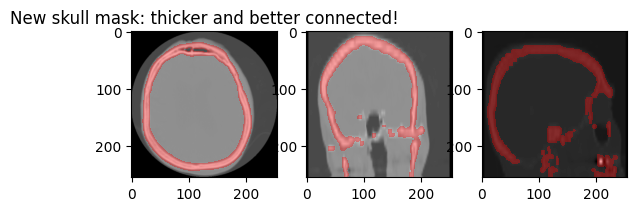

In [6]:
# Our skull is a single bone structure. In our image, though, we can observe objects 'deattached' from the segmented skull.
# How can we improve our skull segmentation using morphological operations? 

''' 1) Introducing morphological operations and connected component analysis (CCA). Consulting ChatGPT, answer the following questions:
       1a) What is CCA?
       Answer: 
       
       1b) What are morphological operations?
       Answer:
       
       1b) Which kind of data do the morphological operations support?
       Answer:
        
       

    2) Lets check how many clusters are in our image.  We can do so by evaluating, for each voxel, its 3D connectivity. 
       
       The concept: we open a 3D patch centered at the voxel of interest and we look at the neighbouring voxels. Connectivity in 3D can
       be defined using 6, 18, 26 'neigbours'. Then, neighbours sharing the same label as the voxel of interest are considered
       'connected'. By analysing the full image, we can obtain clusters of connected elements (components).

       Our idea: the skull is a single structure, and it should be identified as a single connected component. 
       How many objects are connected in our mask?
       
       '''

from scipy import stats as st
import cc3d

# How many elements are connected in 3D?
labelled_cc = cc3d.connected_components(skull_msk, connectivity=6)
print('Number of 3d clusters:', labelled_cc.max())


''' 3) Lets improve our segmentation using morphological dilation operations.
    The idea: On one hand, deattached objects close to the largest element (i.e. the skull) can be 'connected' to it. On the other hand,
    the mask will be 'dilated', thus increasing its thickness. '''


# Post-processing the skull segmentation with binary dilations. 
from scipy.ndimage import binary_dilation
skull_msk_pp = binary_dilation(skull_msk, structure=np.ones((5,5,5)))

# How many elements are now connected in 3D?
labelled_cc_pp = cc3d.connected_components(skull_msk_pp, connectivity=6)
print('Number of 3d clusters in the post-processed mask:', labelled_cc_pp.max())
print('We have connected {} clusters that before were de-attached!'.format(labelled_cc.max() - labelled_cc_pp.max()))

plt.figure()
plt.subplot(1,3,1)
plt.imshow(np.rot90(ct_resized[:,:,160]), cmap='gray')
plt.imshow(np.rot90(skull_msk_pp[:,:,160]), cmap=cmap, alpha=0.35) 
plt.title('New skull mask: thicker and better connected!')

plt.subplot(1,3,2)
plt.imshow(np.rot90(ct_resized[:,160,:]), cmap='gray')
plt.imshow(np.rot90(skull_msk_pp[:,160,:]), cmap=cmap, alpha=0.35) 
plt.subplot(1,3,3)
plt.imshow(np.rot90(ct_resized[160,:,:]), cmap='gray')
plt.imshow(np.rot90(skull_msk_pp[160,:,:]), cmap=cmap, alpha=0.35) 

print('Good job ;)')

## Can we generate a 3D reconstruction of the segmented skull?

**For doing so we can use the marching-cubes algorithm. You are requested to:**

1) Ask ChatGPT what is the algorithm used for.
2) Reconstruct the skull in 3D asking ChatGPT to code for you. For doing so, ask to use marching cubes algorithm and to visualize
    the 3D reconstruction.

Note: If you have issues, the next cell provides an answer given by ChatGPT. 


In [7]:
''' Marching-cubes rendering- Cheat sheet''' 

# from skimage.measure import marching_cubes
# from mpl_toolkits.mplot3d import Axes3D

# vertices, faces, _, _ = marching_cubes(skull_msk_pp, level=0.5)
# print('Marching cubes finished')

# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Plot vertices
# ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='r', marker='.', alpha=0)

# # Plot triangles (faces)
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='skyblue', alpha=1)

# # # Set labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Skull Reconstruction')

# # Customize view (rotate the plot)
# ax.view_init(elev=15, azim=95)  # Set the elevation and angle
# plt.show()


' Marching-cubes rendering- Cheat sheet'

In [8]:
''' Clustering techniques.
    In order to cluster data we need to priorly extract some information (features) from it.
    How can we extract features from the segmented skull? 

    1)  Lets start by cleaning our skull mask and by excluding all objects that are not connected to the largest element using CCA. 
        Idea: we assume that the largest connected component represents the skull; dis-connected objects might be, for instance, image noise.
''' 

# Isolate largest cluster.
largest_cc = st.mode(labelled_cc_pp[labelled_cc_pp!=0]).mode 

# We can get the skull exluding dis-connected objects.
skull_msk_pp = labelled_cc==largest_cc
labelled_cc_pp = cc3d.connected_components(skull_msk_pp, connectivity=6)

print('Our new skull mask has {} object, as desired'.format(labelled_cc_pp.max()))

      
''' 2) Multiple tools exist for extracting features from an image. Here, we will extract geometrical features from the binary skull mask.
    The 'regionprops' function of the package skimage allows us to get some information. 
    Asking GPT how we can use it, similar results to the code below are found. '''

from skimage import measure

label_skull = measure.label(skull_msk_pp)
regions = measure.regionprops(label_skull)

# Print some features extracted
for region in regions:
    print("Area:", region.area)  # Number of pixels in region
    print("Centroid:", region.centroid)  # Centroid coordinates (row, column)
    print("Bounding Box:", region.bbox)  # Bounding box coordinates (min_row, min_col, max_row, max_col)
    print("Major Axis Length:", region.major_axis_length)  # Length of major axis of ellipse

''' 3) Lets get a structured table of the extracted features. We can define the features we want to extract. '''
regions_table = measure.regionprops_table(label_skull, properties=('area', 'major_axis_length', 'axis_minor_length', 'area_filled'))
print(regions_table)


Our new skull mask has 1 object, as desired
Area: 1089695.0
Centroid: (115.43671027214037, 118.12233239576211, 137.50864599727447)
Bounding Box: (21, 6, 0, 218, 256, 248)
Major Axis Length: 307.2558609372844
{'area': array([1089695.]), 'major_axis_length': array([307.25586094]), 'axis_minor_length': array([245.57938393]), 'area_filled': array([1090159.])}


In [9]:
''' Populating a dataset using the techniques learnt till now.
    Goal: generate a tabular dataset in the form [samples X features]. 
    Such dataset will be used to cluster the scans based on the extracted features.
    
    Note: this cell might take some time to run.'''
    
import pandas as pd

all_images = glob.glob(os.path.join(data_path, '*.nii.gz'))
dataset_w_features = []

# Iterate over the 10 images and repeat all steps we have done so far. 
for image_path in all_images:
    # Load the data
    ct_image = nib.load(image_path).get_fdata()

    # standardize all images to a unique dimension
    ct_resized = resize(ct_image, (128, 128, 128), anti_aliasing=True)
    # # segment skull and post-process it
    skull_msk = ct_resized > 700
    skull_msk_pp = binary_dilation(skull_msk, structure=np.ones((5,5,5)))

    # Isolate largest cluster -> skull
    labelled_cc_pp = cc3d.connected_components(skull_msk_pp, connectivity=6)
    largest_cc = st.mode(labelled_cc_pp[labelled_cc_pp!=0]).mode 
    
    # # We can get the skull exluding dis-connected objects.
    skull_msk_pp = labelled_cc_pp==largest_cc

    # Extract features using region_props 
    label_skull = measure.label(skull_msk_pp)
    regions_table = measure.regionprops_table(label_skull, properties=('area', 'major_axis_length', 'axis_minor_length', 'area_filled'))
    dataset_w_features.append(regions_table)

# convert to pandas dataframe
db = pd.DataFrame(dataset_w_features)

# Function to convert arrays to scalar if they contain a single element
def unwrap_array(x):
    if isinstance(x, np.ndarray) and len(x) == 1:
        return x.item()
    return x

# Apply the function to each cell of the DataFrame --> Just to accomodate the data returned by regionprops...
db = db.applymap(unwrap_array)

print(db)


/var/folders/9j/9nd6ksj93_3bp16hqxz7gsb80000gp/T/ipykernel_37477/1574162024.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


       area  major_axis_length  axis_minor_length  area_filled
0  251294.0         149.933592          96.260057     251296.0
1  360783.0         158.350532         101.420848     360826.0
2  229451.0         147.902999          97.296702     229451.0
3  312557.0         159.558645         103.318295     312650.0
4  297523.0         152.402705         103.098202     297527.0
5  261071.0         155.096860          92.720302     261110.0
6  404374.0         159.342585         122.145485     404374.0
7  333251.0         161.840464         105.565606     333263.0
8  236561.0         147.767638         100.205324     236562.0


/var/folders/9j/9nd6ksj93_3bp16hqxz7gsb80000gp/T/ipykernel_37477/1574162024.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db = db.applymap(unwrap_array)


## Clustering the data with k-Means

Using the above-extracted features, apply k-Means algorithm to cluster the data samples and visualize them.
Lets imagine that two groups (clusters) are expected to be found.

**Note: You can get help from GPT ;)**